# GARCH Model Testing

In [136]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler


In [137]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')
print(df.head())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month   Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
0 2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
1 2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2 2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
3 2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
4 2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

   Cardano  USD Coin    VIX   MOVE  LFPR      CPI     r      M1    GDP  \
0      NaN       NaN  10.59  52.88  63.1  246.819  1.15  3535.6  60099   
1      NaN       NaN   9.51  51.15  62.7  246.663  1.15  3615.0  60674   
2      NaN       NaN  10.18  46.83  62.7  246.669  1.16  3587.6  60674   
3      NaN       NaN  11.28  46.60  62.7  246.524  1.30  3630.5  60674   
4      NaN       NaN  11.04  57.20  62.7  247.867  1.41  3673.4  61093   

         IM        EX     CC  CC Monthly % Change  Bitcoin Price  GDP Monthly  
0  2916.022  2535.501   

## Testing all combinations

In [138]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin','Bitcoin Price']
order = 1
train_end = '2023-05-01'

results_list = []

In [139]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

## Forecasting Macro Mean

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()

        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]])

        try:
            model = arch_model(
                y_scaled,
                mean='ARX',
                lags=1,
                vol='GARCH',
                p=1,
                q=1,
                x=x_scaled,
                dist='normal'
            )
            res = model.fit(disp='off')

            # Collect exogenous regressor results, if present
            exog_params = [p for p in res.params.index if p.startswith('x')]
            if exog_params:
                for p_name in exog_params:
                    results.append({
                        'Macro': macro,
                        'Macro_col': y_col,
                        'Crypto': asset,
                        'Param': p_name,
                        'Coef': res.params[p_name],
                        'P-value': res.pvalues[p_name],
                        'AIC': res.aic,
                        'BIC': res.bic,
                        'Model_Success': True,
                    })
            else:
                # No exogenous regressor included
                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': None,
                    'Coef': np.nan,
                    'P-value': np.nan,
                    'AIC': res.aic,
                    'BIC': res.bic,
                    'Model_Success': True,
                })

            # print(f"Model fit successful for {macro}-{asset}")

        except Exception as e:
            print(f"Error fitting model for {macro}-{asset}: {e}")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'Model_Success': False,
            })

# After loop, build and display results DataFrame
results_df = pd.DataFrame(results)

# Display full DataFrame without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by=['P-value'], na_position='last'))


In [ ]:
def plot_actual_vs_predicted(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # Align for ARX(1): y[t] = const + phi*y[t-1] + beta*x[t]
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_mean_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )

    # Actual y from t=1 onward
    y_actual_scaled = y_scaled[1:]

    # Inverse transform to original scale
    predicted_mean = scaler_y.inverse_transform(predicted_mean_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_temp.index[-len(predicted_mean):], y_actual, label='Actual', marker='o')
    plt.plot(df_temp.index[-len(predicted_mean):], predicted_mean, label='Predicted Mean', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted {y_col} using {asset} in GARCH Mean')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.show()

    from sklearn.metrics import mean_squared_error, r2_score

    r2 = r2_score(y_actual, predicted_mean)
    mse = mean_squared_error(y_actual, predicted_mean)

    print(f"R²: {r2:.4f}, MSE: {mse:.4f}")


In [ ]:
def plot_actual_vs_predicted_with_baseline(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score
    from arch import arch_model

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # ---------- ARX(1) model predictions (with crypto) ----------
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_arx_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )
    y_actual_scaled = y_scaled[1:]

    predicted_arx = scaler_y.inverse_transform(predicted_arx_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # ---------- AR(1) baseline model (no crypto) ----------
    model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
    res_ar = model_ar.fit(disp="off")
    predicted_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
    predicted_ar = scaler_y.inverse_transform(predicted_ar_scaled.reshape(-1, 1)).flatten()

    # Align everything to same length
    y_actual_plot = y_actual[-len(predicted_ar):]
    predicted_arx_plot = predicted_arx[-len(predicted_ar):]

    # ---------- Plot ----------
    idx = df_temp.index[-len(predicted_ar):]

    plt.figure(figsize=(10, 6))
    plt.plot(idx, y_actual_plot, label='Actual', marker='o',markersize=1)
    plt.plot(idx, predicted_ar, label='Predicted AR(1)', linestyle='--', marker='x',markersize=1)
    plt.plot(idx, predicted_arx_plot, label=f'Predicted ARX(1) + {asset}', linestyle='--', marker='s',markersize=1)
    plt.title(f'Actual vs Predicted {y_col} with and without {asset}')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Metrics ----------
    print("Model Comparison Metrics:")
    print(f"{'Metric':<10} | {'AR(1)':<12} | {'ARX + ' + asset:<15}")
    print("-" * 40)
    print(f"{'R²':<10} | {r2_score(y_actual_plot, predicted_ar):<12.4f} | {r2_score(y_actual_plot, predicted_arx_plot):<15.4f}")
    print(f"{'MSE':<10} | {mean_squared_error(y_actual_plot, predicted_ar):<12.4f} | {mean_squared_error(y_actual_plot, predicted_arx_plot):<15.4f}")


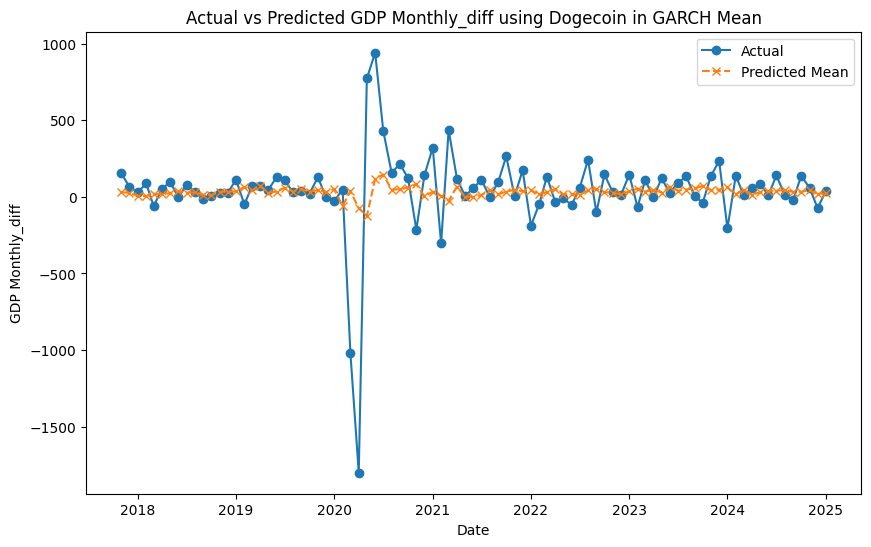

R²: 0.0332, MSE: 78128.8347


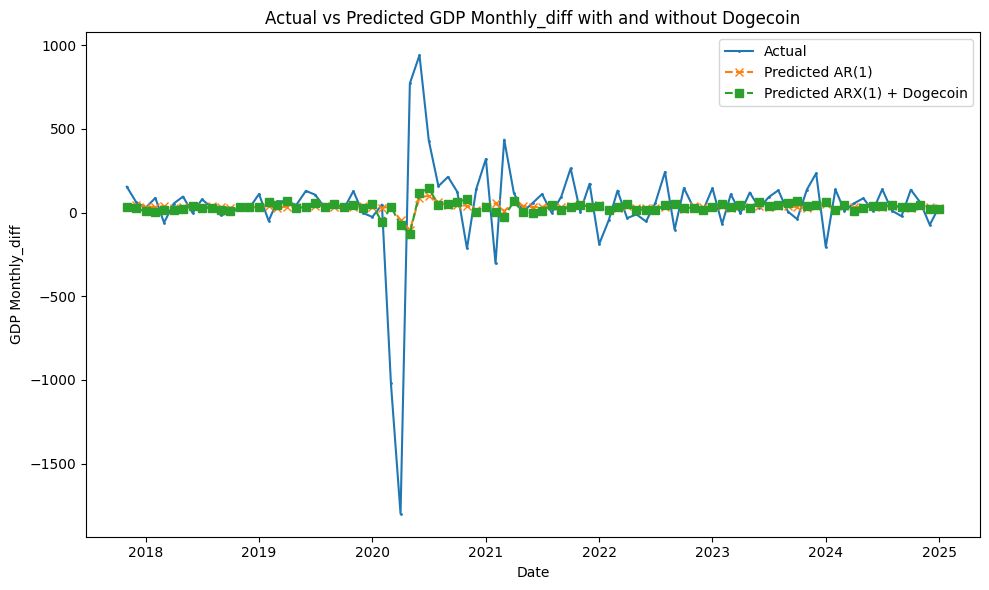

Model Comparison Metrics:
Metric     | AR(1)        | ARX + Dogecoin 
----------------------------------------
R²         | 0.0208       | 0.0332         
MSE        | 79131.9573   | 78128.8347     


In [ ]:
# replace this with pairs as needed
plot_actual_vs_predicted(df, 'GDP Monthly', 'Dogecoin', res)
plot_actual_vs_predicted_with_baseline(df, 'GDP Monthly', 'Dogecoin', res)